In [19]:
import os
import pandas as pd
import nltk
import requests
import string
from gensim.models import Word2Vec, KeyedVectors
import shutil
import numpy as np
import re
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import shap


In [3]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [2]:
df_balanced = pd.read_csv("../dataset/embled_review_combined.csv", encoding='utf-8')

In [4]:
df_balanced.head(1)

,rating,location_id,review,cleaned_review,embedding,sentiment
0,3,4322585,This was an ornate wat inside Mae Sot. It is a...,ornate wat inside mae sot burmese style wat ty...,[[ 0. 0. 0. ... 0. ...,neutral


In [5]:
df_balanced['embedding'][0]

'[[ 0.          0.          0.         ...  0.          0.\n   0.        ]\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]\n ...\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]\n [-0.00701559  0.28866604  0.02099591 ... -0.07148592  0.21406499\n  -0.04538575]\n [ 0.          0.          0.         ...  0.          0.\n   0.        ]]'

In [ ]:
def convert_embedding(embedding):
    # If the embedding is already a numpy array, return it as is
    if isinstance(embedding, np.ndarray):
        return embedding.flatten()  # Flatten if it's a 2D numpy array
    
    # If the embedding is a string, clean and parse it
    if isinstance(embedding, str):
        # Clean up the embedding string: replace newlines and ensure proper spacing
        embedding = embedding.replace("\n", " ").replace("...", "")
        # Remove extra spaces and brackets for easier parsing
        embedding = embedding.replace("[", "").replace("]", "").strip()
        
        try:
            # Split the cleaned string by spaces and convert it to a list of floats
            embedding_list = [float(val) for val in embedding.split()]
            # Convert the list into a numpy array
            embedding_array = np.array(embedding_list)
            
            # Flatten if it's a 2D array (e.g., matrix)
            return embedding_array.flatten()
        
        except ValueError:
            print(f"Error parsing embedding: {embedding}")
            # Return a zero-vector if there's an issue with parsing
            return np.zeros(300)  # Adjust size as needed
    
    # If it's neither a string nor a numpy array, return a default zero vector
    print(f"Unexpected data type: {type(embedding)}")
    return np.zeros(300)  # Adjust size as needed

In [7]:
df_balanced['embedding'] = df_balanced['embedding'].apply(convert_embedding)

In [17]:
df_balanced['length'] = df_balanced['cleaned_review'].apply(lambda x: len(x.split()))

# Calculate statistics
total_reviews = len(df_balanced)
max_length = df_balanced['length'].max()
min_length = df_balanced['length'].min()
avg_length = df_balanced['length'].mean()

In [ ]:
# Parameters
embedding_size = 300  # Assuming Word2Vec has 300 dimensions
gru_units = 128
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_sequence_length = 300  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

In [9]:
sentences = [row.split() for row in df_balanced['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=embedding_size, window=5, min_count=1, workers=4) 

In [10]:
tokenizer = Tokenizer(num_words=max_features, oov_token="OOV")
tokenizer.fit_on_texts(df_balanced['cleaned_review'])

X = tokenizer.texts_to_sequences(df_balanced['cleaned_review'])
X = pad_sequences(X, maxlen=max_sequence_length)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = df_balanced['sentiment'].map(label_mapping)

In [11]:
print(f"X {X.shape}")
print(f"X {y.shape}")

X (14067, 300)
X (14067,)


In [12]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [20]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.3, random_state=42)

# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")

X_train shape: (9846, 300)
y_train shape: (9846,)
X_test shape: (4221, 300)
y_test shape: (4221,)


In [21]:
# Step 6: Build the LSTM Model
dropout_rate = 0.5
input_shape = X_train_resampled.shape[1:] 

# สร้างโมเดลด้วย L2 Regularization และ Dropout
# CNN model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_sequence_length))
model_cnn.add(Conv1D(128, kernel_size=5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()

/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_size))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [23]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train_resampled)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Normalize class weights
total = sum(class_weights_dict.values())
class_weights_dict = {k: v / total for k, v in class_weights_dict.items()}

In [24]:
class_weights_dict = dict(enumerate(class_weights))

In [37]:
class_weights_dict

{0: 1.0064271107215892, 1: 0.9869646182495344, 2: 1.0068683326026597}

In [24]:

# กำหนดการตั้งค่า Early Stopping และ Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../../models/CNN_models_sample.keras', monitor='val_loss', save_best_only=True)  # เปลี่ยนจาก .h5 เป็น .keras

# ฝึกโมเดล

history = model_cnn.fit(X_train_resampled, 
                 y_train_resampled, 
                 epochs=20, 
                 batch_size=128, 
                 callbacks=[early_stopping, model_checkpoint],
                 validation_data=(X_val, y_val),
                 class_weight=None)



Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.3668 - loss: -13.5025 - val_accuracy: 0.3641 - val_loss: -67.0093
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.4014 - loss: -120.9207 - val_accuracy: 0.3537 - val_loss: -325.3991
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.3812 - loss: -500.6959 - val_accuracy: 0.3710 - val_loss: -914.9922
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.4131 - loss: -1204.0992 - val_accuracy: 0.3577 - val_loss: -1909.4454
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.3896 - loss: -2481.7363 - val_accuracy: 0.3618 - val_loss: -3452.8638
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.4008 - loss: -4226.3164 - val_accuracy: 0.3580 - val_loss: -5557.8813
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.3915 - loss: -6861.2861 - val_accuracy: 0.3611 - val_loss: -8376.4854
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 

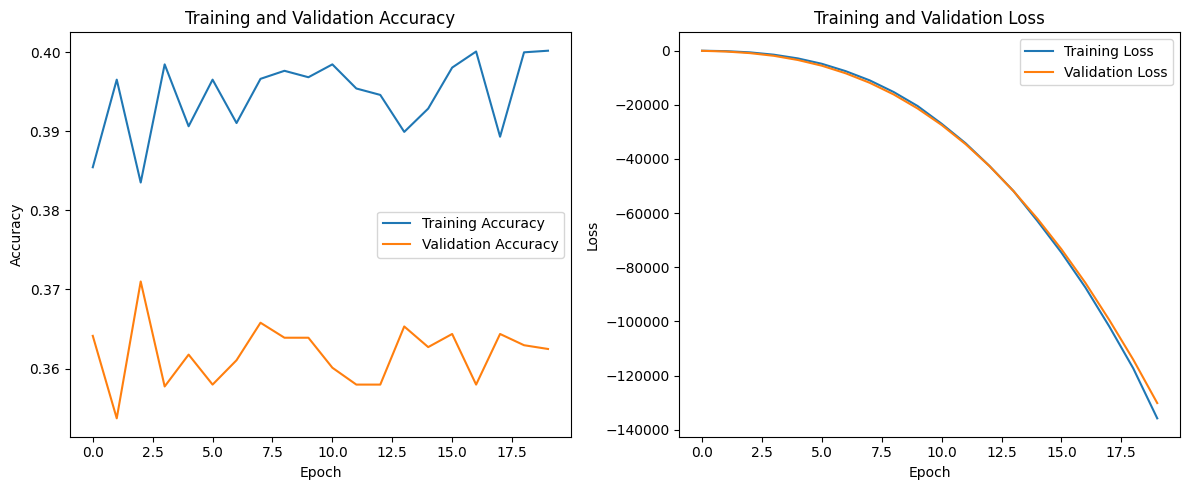

In [25]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']      # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']         # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.models import load_model

# โหลดโมเดล LSTM ที่ดีที่สุด
best_model = load_model('../../models/CNN_models_sample.keras')

In [27]:
# ใช้โมเดล LSTM ทำนายข้อมูล validation set
cnn_preds = best_model.predict(X_val)
cnn_preds = np.argmax(cnn_preds, axis=1)

# ฝึก Gradient Boosting Classifier บนผลลัพธ์จาก LSTM
# gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
# gb_clf.fit(lstm_preds.reshape(-1, 1), y_val)

# ทำนายผลลัพธ์ด้วย Gradient Boosting
# ensemble_preds = gb_clf.predict(lstm_preds.reshape(-1, 1))

# ตรวจสอบผลลัพธ์
print(classification_report(y_val, cnn_preds))
print(confusion_matrix(y_val, cnn_preds))

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.34      1.00      0.51      1453
           1       0.00      0.00      0.00      1374
           2       0.00      0.00      0.00      1394

    accuracy                           0.34      4221
   macro avg       0.11      0.33      0.17      4221
weighted avg       0.12      0.34      0.18      4221

[[1453    0    0]
 [1374    0    0]
 [1394    0    0]]


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python

In [28]:
from sklearn.metrics import  precision_score, recall_score, f1_score
precision = precision_score(y_val, cnn_preds, average='weighted')
recall = recall_score(y_val, cnn_preds, average='weighted')
f1 = f1_score(y_val, cnn_preds, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.1185
Recall: 0.3442
F1-Score: 0.1763


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
lstm_preds = best_model.predict(X_val)
lstm_preds = np.argmax(lstm_preds, axis=1)

print(classification_report(y_val, lstm_preds))
print(confusion_matrix(y_val, lstm_preds))

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.34      1.00      0.51       589
           1       0.00      0.00      0.00       544
           2       0.00      0.00      0.00       590

    accuracy                           0.34      1723
   macro avg       0.11      0.33      0.17      1723
weighted avg       0.12      0.34      0.17      1723

[[589   0   0]
 [544   0   0]
 [590   0   0]]


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python

In [31]:
# สร้างโมเดล Random Forest (Bagging)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_predictions = rf_model.predict(X_val)

# สร้างโมเดล Gradient Boosting (Boosting)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_resampled, y_train_resampled)
gb_predictions = gb_model.predict(X_val)

# วัดผลลัพธ์ของแต่ละโมเดล
print("Random Forest Accuracy:", accuracy_score(y_val, rf_predictions))
print("Gradient Boosting Accuracy:", accuracy_score(y_val, gb_predictions))

Random Forest Accuracy: 0.8276262333139872
Gradient Boosting Accuracy: 0.6604759141033082


In [97]:
# Ensemble วิธี Voting (Hard Voting)
from sklearn.ensemble import VotingClassifier

# รวมโมเดลทั้งสองด้วยการ Voting
voting_model = VotingClassifier(estimators=[
    ('rf', rf_model), ('gb', gb_model)],
    voting='hard')

voting_model.fit(X_train_resampled, y_train_resampled)
voting_predictions = voting_model.predict(X_val)

# วัดผลลัพธ์จากการใช้ Voting
print("Voting Ensemble Accuracy:", accuracy_score(y_val, voting_predictions))

Voting Ensemble Accuracy: 0.6993615786419036


In [98]:
y_val

4205    2
1665    1
3121    2
3126    2
3688    0
       ..
8510    1
7445    2
2132    0
247     1
4011    2
Name: sentiment, Length: 1723, dtype: int64

In [112]:
common_indices = y_val.index.intersection(review_df.index)
missing_indices = y_val.index.difference(review_df.index)
print(f"Common indices count: {len(common_indices)}")
print(f"Missing indices count: {len(missing_indices)}")

Common indices count: 1170
Missing indices count: 553


In [110]:
# y_val = y_val.iloc[:-1]

In [107]:
predict_label = y_val

In [113]:
redicted_df = pd.DataFrame({'predicted': ensemble_preds}, index=y_val.index)
    
    # Concatenate y_val and the new predicted_df to create a new DataFrame
predict_df = pd.concat([y_val, redicted_df], axis=1)

In [115]:
predict_df

,sentiment,predicted
4205,2,1
1665,1,1
3121,2,2
3126,2,1
3688,0,0
...,...,...
8510,1,1
7445,2,2
2132,0,0
247,1,1


In [116]:
valid_y_val = predict_df.loc[predict_df.index.isin(review_df.index)]

# Now you can safely use .loc with valid_y_val indices
filtered_reviews = review_df.loc[valid_y_val.index]

In [117]:
filtered_reviews

,helpful_votes,location_id,review_id,review,review_subject,trip_type,rating,location_name,province,place_id,emotion,cleaned_review,embedding,sentiment
4205,0,11867768,660193827,"The place is a real gem, nestling in the cool ...",Not to be Missed!,Couples,5,The Royal Agricultural Station Angkhang,Phetchabun,P03012884,joy,place real gem nestling cool green upland doi ...,"[[-0.0031354371458292007, 0.08185625076293945,...",positive
1665,0,16868178,893223254,"Nice view, but you need to be be careful when ...",Nice view,Friends getaway,5,Chado Cliff Viewpoint,Phra Nakhon Si Ayutthaya,P03017905,joy,nice view need careful hiking natural trail be...,"[[-0.026523858308792114, 0.24474334716796875, ...",positive
3121,1,556614,874997345,Doi Mae Salong is a beautiful and interesting ...,Beautiful and peaceful,NONE,5,Doi Mae Salong,Nakhon Sawan,P03016134,joy,doi mae salong beautiful interesting place vis...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
3126,0,6669517,632751727,Located on the way we back to our accommodatio...,temple that next to the road,Couples,3,Chedi Phra Borommasaririkkathat Khao Kho,Nakhon Sawan,P03016132,joy,located way back accommodation look time avail...,"[[-0.010012944228947163, 0.07716846466064453, ...",neutral
3688,1,7659431,613000573,i stayed on koh larn at the castello resort ov...,i love this island so much,Solo travel,5,Thong Lang Beach,Sukhothai,P03025214,joy,stayed koh larn castello resort christmas enjo...,"[[5.367626727093011e-05, 0.012896074913442135,...",positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0,8874054,875897422,Chaio por Phawo Shrine is the most popular pra...,Most Respect shine in Mae sot People,NONE,5,Chao Por Phawo Shrine,Nonthaburi,P03016494,joy,chaio por phawo shrine popular pray respect pl...,"[[-0.013652702793478966, 0.11288685351610184, ...",positive
4129,1,1307603,750690836,Took a fast boat for a magical day at Hapla Be...,Blissful,Couples,5,Koh Kho Khao Island,Phetchabun,P03004050,joy,took fast boat magical day hapla beach real ro...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
2132,0,554864,696305303,in the twelfe-year animal cycle the rabbit is ...,the rabbit temple,Couples,5,Wat Phrathat Chae Haeng,Sing Buri,P03013402,joy,twelfeyear animal cycle rabbit one wat phra ch...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
247,0,25571501,929540899,We went on a weekday and was pleased that this...,Best Jodd Fair,Friends getaway,5,Jodd Fairs DanNeramit,Bangkok,P03022261,joy,went weekday pleased jodd fair wasnt packed ma...,"[[-0.0012631779536604881, 0.031852032989263535...",positive


In [150]:

predictions_df = pd.DataFrame({
    'location_id': filtered_reviews['location_id'],
    'location_name': filtered_reviews['location_name'],
    'trip_type': filtered_reviews['trip_type'],
    'rating': filtered_reviews['rating'],
    'helpful_voting': filtered_reviews['helpful_votes'],
    'review_text': filtered_reviews['review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': predict_df['sentiment'],  # The actual sentiment labels
    'predicted_sentiment': predict_df['predicted']  # The predicted sentiment labels
})

# predictions_df['actual_sentiment'] = predictions_df['actual_sentiment'].map(label_mapping)
# predictions_df['predicted_sentiment'] = predictions_df['predicted_sentiment'].map(label_mapping)

predictions_df.head(5)


,location_id,location_name,trip_type,rating,helpful_voting,review_text,actual_sentiment,predicted_sentiment
8,2273363.0,Wat Rajapradit Sathitmahasimaram Rajaworavihara,NONE,5.0,2.0,One of the least crowded temples but very beau...,2,1
14,311043.0,Wat Phra Chetuphon,Couples,5.0,0.0,"The designs, the Buddhas, and other figures fe...",1,1
17,317504.0,Temple Of Dawn (Wat Arun),Solo travel,5.0,15.0,"Known as Temple of Dawn, I went to this temple...",0,0
19,317504.0,Temple Of Dawn (Wat Arun),Family,4.0,0.0,I have to admit that this is a place i have al...,0,0
23,456322.0,Wat Umong,Family,5.0,0.0,The visit to this temple was a good pick for u...,1,2


In [151]:
predictions_df.to_csv('./output/LSTM_predictions.csv')

In [138]:
y_val = y_val.astype(int)
ensemble_preds_class = ensemble_preds.astype(int)


In [139]:
print(y_val.shape)            # Shape of y_val
print(ensemble_preds.shape) 

(1723,)
(1723,)


In [140]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score directly using ensemble_preds
precision = precision_score(y_val, ensemble_preds, average='weighted')
recall = recall_score(y_val, ensemble_preds, average='weighted')
f1 = f1_score(y_val, ensemble_preds, average='weighted')

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Precision: 0.6930
Recall: 0.6883
F1-Score: 0.6807


In [167]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Assume y_test contains true class labels, and y_pred_prob contains predicted probabilities

# Binarize the output labels for calculating AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 3 classes: 0, 1, 2

# Calculate the AUC for each class
auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_test_bin, y_pred_prob, average='micro', multi_class='ovr')

print(f'Macro-Averaged AUC: {auc_macro:.4f}')
print(f'Micro-Averaged AUC: {auc_micro:.4f}')

Macro-Averaged AUC: 0.5000
Micro-Averaged AUC: 0.8566


In [165]:
from sklearn.metrics import log_loss

# Calculate log loss
log_loss_value = log_loss(y_test, y_pred_prob)
print(f'Log Loss: {log_loss_value:.4f}')

Log Loss: 0.7264


In [166]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_class)
print(f"Cohen's Kappa: {kappa:.4f}")

Cohen's Kappa: 0.0000
